# Homework 3

# Code + Report

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter
from lifelines import GeneralizedGammaRegressionFitter, CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

## 1) Import data

In [2]:
df = pd.read_csv("telco.csv")
df.head()

,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No


## 2) Basic cleaning and EDA

In [3]:
# Ensure numeric time
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')

# Convert churn to binary
df['churn'] = df['churn'].map({'Yes': 1, 'No': 0})

In [4]:
# Quick stats
print(df.shape)
print(df[['tenure','age','income']].describe())

# Check missing values
print(df.isna().sum())

(1000, 15)
            tenure          age       income
count  1000.000000  1000.000000  1000.000000
mean     35.526000    41.684000    77.535000
std      21.359812    12.558816   107.044165
min       1.000000    18.000000     9.000000
25%      17.000000    32.000000    29.000000
50%      34.000000    40.000000    47.000000
75%      54.000000    51.000000    83.000000
max      72.000000    77.000000  1668.000000
ID          0
region      0
tenure      0
age         0
marital     0
address     0
income      0
ed          0
retire      0
gender      0
voice       0
internet    0
forward     0
custcat     0
churn       0
dtype: int64


## 3) Preprocess categorical variables for regression models

In [5]:
# Choose predictors (drop ID, tenure, churn)
drop_cols = ['ID','tenure','churn']
candidate_cols = [c for c in df.columns if c not in drop_cols]

In [6]:
# one-hot encoding categoricals and scaling numerics
categorical_cols = df[candidate_cols].select_dtypes(include=['object','category']).columns.tolist()
numeric_cols = [c for c in candidate_cols if c not in categorical_cols]

In [7]:
# Example: if ed is numeric-coded rather than object, it will be in numeric_cols
print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

Categorical: ['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat']
Numeric: ['age', 'address', 'income']


In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ],
    remainder='drop'
)

In [9]:
preprocessor.fit(df[candidate_cols])
ohe_feature_names = []

if len(categorical_cols) > 0:
    enc = preprocessor.named_transformers_['cat']
    cat_names = enc.get_feature_names_out(categorical_cols).tolist()
    ohe_feature_names.extend(cat_names)
ohe_feature_names.extend(numeric_cols)

In [10]:
X = pd.DataFrame(preprocessor.transform(df[candidate_cols]), columns=ohe_feature_names, index=df.index)
X.shape

(1000, 18)

In [11]:
data = pd.concat([df[['tenure','churn']].rename(columns={'tenure':'duration','churn':'event'}), X], axis=1)
data.head()

,duration,event,region_Zone 2,region_Zone 3,marital_Unmarried,ed_Did not complete high school,ed_High school degree,ed_Post-undergraduate degree,ed_Some college,retire_Yes,gender_Male,voice_Yes,internet_Yes,forward_Yes,custcat_E-service,custcat_Plus service,custcat_Total service,age,address,income
0,13,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,44.0,9.0,64.0
1,11,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,33.0,7.0,136.0
2,68,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,52.0,24.0,116.0
3,33,1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,12.0,33.0
4,23,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,30.0,9.0,30.0


## 4) Fit several AFT regression models
###    We will fit:
###       - WeibullAFTFitter
###     - LogNormalAFTFitter
###       - LogLogisticAFTFitter
###    Also fit CoxPH for comparison

In [12]:
models = {}
results = []

In [13]:
aft_models = [
    ("WeibullAFT", WeibullAFTFitter()),
    ("LogNormalAFT", LogNormalAFTFitter()),
    ("LogLogisticAFT", LogLogisticAFTFitter()),
]

In [14]:
# Fit each model (may take time for GeneralizedGamma)
for name, model in aft_models:
    print("Fitting", name)
    model.fit(data, duration_col='duration', event_col='event', show_progress=False)
    models[name] = model
    ll = model.log_likelihood_
    aic = model.AIC_ if hasattr(model,'AIC_') else ( -2*ll + 2*model.params_.shape[0] )
    cindex = model.score(data, scoring_method="concordance_index")  # lifelines score uses concordance
    results.append({
        'model': name,
        'log_likelihood': ll,
        'AIC': aic,
        'concordance_index': cindex
    })
    print(name, "AIC:", aic, "C-index:", cindex)

Fitting WeibullAFT
WeibullAFT AIC: 2964.3432480838806 C-index: 0.7838180266174188
Fitting LogNormalAFT
LogNormalAFT AIC: 2954.0240102517128 C-index: 0.7872163376621982
Fitting LogLogisticAFT
LogLogisticAFT AIC: 2956.2085614433336 C-index: 0.7872217062420478


In [15]:
cph = CoxPHFitter()
cph.fit(data, duration_col='duration', event_col='event')
models['CoxPH'] = cph
results.append({
    'model': 'CoxPH',
    'log_likelihood': cph.log_likelihood_,
    'AIC': cph.AIC_partial_,
    'concordance_index': cph.concordance_index_
})

summary_df = pd.DataFrame(results).sort_values('AIC')
print(summary_df)

            model  log_likelihood          AIC  concordance_index
1    LogNormalAFT    -1457.012005  2954.024010           0.787216
2  LogLogisticAFT    -1458.104281  2956.208561           0.787222
0      WeibullAFT    -1462.171624  2964.343248           0.783818
3           CoxPH    -1618.379172  3272.758345           0.783512


## 5) Visualize all survival curves on one plot
###    Two views:
###      - survival for average (mean) covariate profile for each model
###      - survival curves of models for two example segments

In [16]:
plt.figure(figsize=(10,6))
times = np.linspace(0, df['tenure'].max(), 200)

<Figure size 1000x600 with 0 Axes>

In [17]:
# mean covariates
mean_cov = data.drop(columns=['duration','event']).mean().to_frame().T

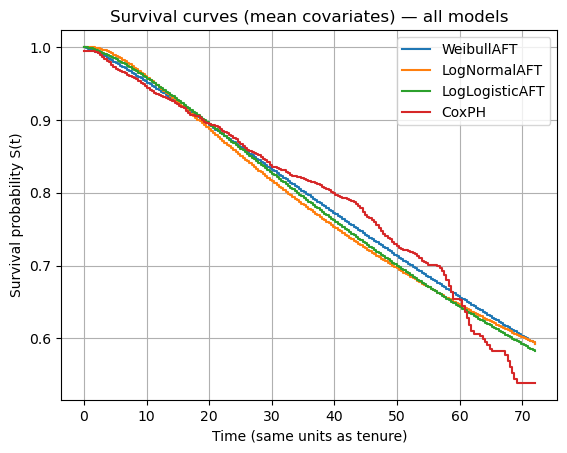

In [18]:
for name, model in models.items():
    try:
        # lifelines AFT models have predict_survival_function
        sf = model.predict_survival_function(mean_cov, times=times)
        # predict_survival_function returns a dataframe (one column per row), choose the first column
        if isinstance(sf, pd.DataFrame):
            y = sf.iloc[:,0]
        else:
            y = sf
        plt.step(times, y, where='post', label=name)
    except Exception as e:
        # some models may implement different api
        print("Could not plot", name, ":", e)
        
        
        
plt.xlabel("Time (same units as tenure)")
plt.ylabel("Survival probability S(t)")
plt.title("Survival curves (mean covariates) — all models")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Example segment curves: high-income vs low-income (median split)
median_income = df['income'].median()
segA = df[candidate_cols].copy()
segA['income_segment'] = np.where(df['income'] > median_income, 'high', 'low')
# Build covariate rows for high and low
high_row = segA[segA['income_segment']=='high'].iloc[0:candidate_cols.__len__()].iloc[0:candidate_cols.__len__()]

In [20]:
# Create two example covariate vectors (one-hot + numeric) manually
example_high = mean_cov.copy()
example_low = mean_cov.copy()
if 'income' in numeric_cols:
    example_high['income'] = df['income'].quantile(0.75)
    example_low['income'] = df['income'].quantile(0.25)

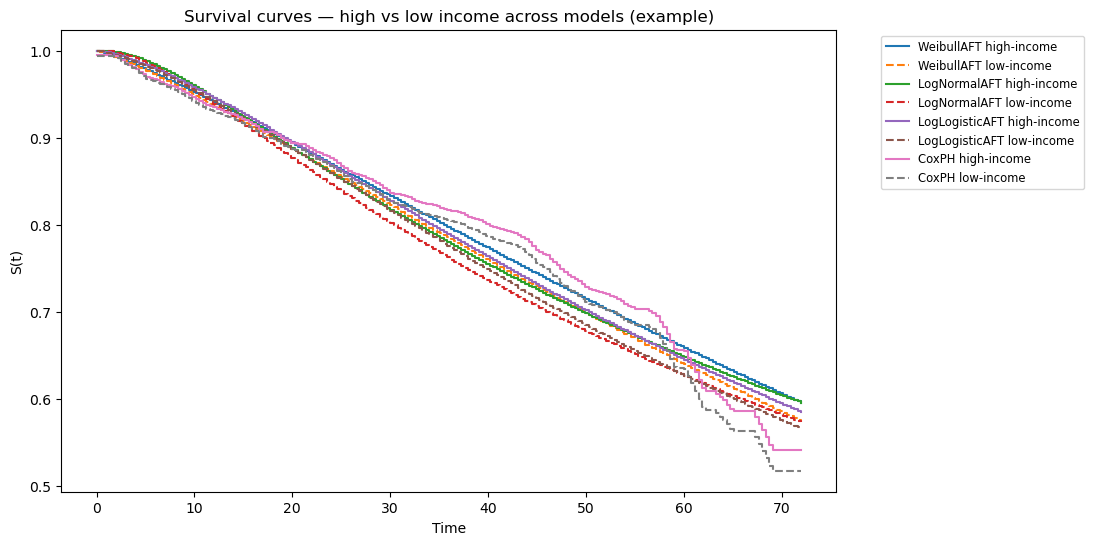

In [21]:
plt.figure(figsize=(10,6))
for name, model in models.items():
    try:
        s_high = model.predict_survival_function(example_high, times=times).iloc[:,0]
        s_low = model.predict_survival_function(example_low, times=times).iloc[:,0]
        plt.step(times, s_high, where='post', linestyle='-', label=f"{name} high-income")
        plt.step(times, s_low, where='post', linestyle='--', label=f"{name} low-income")
    except:
        pass

plt.xlabel("Time")
plt.ylabel("S(t)")
plt.title("Survival curves — high vs low income across models (example)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
plt.show()

## 6) Feature selection: keep significant features (backward elimination by p-value)
###    Run on the best AIC model to select features with p < 0.05

In [22]:
best_model_name = summary_df.iloc[0]['model']
print("Best model per AIC:", best_model_name)

best_model = models[best_model_name]

try:
    full_summary = best_model.summary
    pvals = full_summary["p"]

    significant = [
        idx[1]
        for idx in pvals[pvals < 0.05].index
        if idx[1] != "Intercept"
    ]

    print("Significant predictors:", significant)

except Exception as e:
    print("Could not extract p-values:", e)
    significant = data.drop(columns=["duration","event"]).columns.tolist()

Best model per AIC: LogNormalAFT
Significant predictors: ['address', 'age', 'custcat_E-service', 'custcat_Plus service', 'custcat_Total service', 'internet_Yes', 'marital_Unmarried', 'voice_Yes']


In [23]:
# Fit reduced model
if len(significant) > 0 and best_model_name != "CoxPH":

    reduced_df = pd.concat([data[["duration","event"]], data[significant]], axis=1)

    reduced_model = best_model.__class__()
    reduced_model.fit(reduced_df, duration_col="duration", event_col="event")

    print("Reduced model AIC:", getattr(reduced_model, "AIC_", None))

    models["reduced_" + best_model_name] = reduced_model

else:
    reduced_model = None

Reduced model AIC: 2944.200662919656


## 7) Final model: pick using AIC, C-index, interpretability, and convergence
###    (We choose best_model_name; if reduced model exists, compare metrics)

In [24]:
final_model_name = best_model_name
if reduced_model is not None:
    # compare AICs
    aic_full = summary_df.iloc[0]['AIC']
    aic_reduced = getattr(reduced_model, 'AIC_', np.nan)
    print("Full AIC:", aic_full, "Reduced AIC:", aic_reduced)
    if not np.isnan(aic_reduced) and aic_reduced < aic_full:
        final_model_name = 'reduced_' + best_model_name
        final_model = reduced_model
    else:
        final_model = best_model
else:
    final_model = best_model

print("Final model chosen:", final_model_name)

Full AIC: 2954.0240102517128 Reduced AIC: 2944.200662919656
Final model chosen: reduced_LogNormalAFT


In [25]:
try:
    print(final_model.summary[['coef','se(coef)','p']].sort_values('p'))
except:
    print("Summary not available for final model type")

                                  coef  se(coef)             p
param  covariate                                              
mu_    Intercept              2.534887  0.242611  1.490611e-25
sigma_ Intercept              0.283034  0.046020  7.735690e-10
mu_    internet_Yes          -0.840528  0.138259  1.206593e-09
       custcat_E-service      1.025825  0.169047  1.292752e-09
       age                    0.036826  0.006400  8.695261e-09
       custcat_Plus service   0.822553  0.169425  1.204113e-06
       address                0.042824  0.008847  1.296478e-06
       custcat_Total service  1.013269  0.209579  1.332924e-06
       marital_Unmarried     -0.447317  0.114472  9.319665e-05
       voice_Yes             -0.463493  0.166771  5.448947e-03


## 8) CLV calculation
###    Approach:
###      - For each customer, compute predicted survival probability at discrete times (monthly)
###      - Expected remaining lifetime (in months) = sum_{m=1..T_max} S(m_months)
###      - CLV = sum_{m=1..T_max} (monthly_margin * S(m)) / (1+discount_rate)^{m/12}

In [26]:
duration_in_months = True
def compute_discounted_clv_months(model, covariates_row,
                                  monthly_margin=10.0,
                                  discount_rate_annual=0.10,
                                  months=60,
                                  duration_in_months=True):
    """
    model: fitted lifelines model
    covariates_row: 1-row DataFrame of covariates (same columns used for training)
    months: projection horizon in months (e.g., 60)
    returns: (discounted_clv, expected_months)
    """
    if duration_in_months:
        # timeline: months 1..months passed directly as integers
        timeline = np.arange(1, months+1)
        # lifelines expects time values in same units as training duration
        times_for_model = timeline
    else:
        # durations were in years
        timeline = np.arange(1, months+1)
        times_for_model = timeline / 12.0

    # survival probabilities S(t) at each month
    sf = model.predict_survival_function(covariates_row, times=times_for_model)
    svals = sf.iloc[:,0].values # probability survive beyond each month

    # convert month index to years
    times_years = timeline / 12.0
    discount_factors = (1.0 + discount_rate_annual) ** times_years

    discounted_clv = (monthly_margin * (svals / discount_factors)).sum()
    expected_months = svals.sum()  # expected remaining months

    return float(discounted_clv), float(expected_months)

In [27]:
# Example: compute CLV for all customers using the final model
monthly_margin = 10.0  # assumed margin per month in same currency
discount_rate_annual = 0.10  # 10% annual discount
projection_months = 60

In [28]:
covariates = data.drop(columns=['duration','event'])
clv_list = []
for idx, row in covariates.iterrows():
    cov_row = row.to_frame().T
    clv_val, exp_months = compute_discounted_clv_months(final_model, cov_row,
                                                        monthly_margin=monthly_margin,
                                                        discount_rate_annual=discount_rate_annual,
                                                        months=projection_months,
                                                        duration_in_months=duration_in_months)
    clv_list.append({'index': idx, 'expected_months': exp_months, 'clv': clv_val})

In [29]:
clv_df = pd.DataFrame(clv_list).set_index('index')

meta_cols = [c for c in ['region','custcat','income','age','gender'] if c in df.columns]
clv_df = clv_df.join(df[meta_cols])

print(clv_df.head())

       expected_months         clv  region        custcat  income  age  gender
index                                                                         
0            48.597506  392.530065  Zone 2  Basic service      64   44    Male
1            49.237558  397.275606  Zone 3  Total service     136   33    Male
2            58.918343  467.773344  Zone 3   Plus service     116   52  Female
3            39.189204  321.816026  Zone 2  Basic service      33   33  Female
4            51.683009  415.324385  Zone 2   Plus service      30   30    Male


## 9) Explore CLV within segments

In [30]:
# Example segments: custcat, region
seg_by_custcat = clv_df.groupby('custcat')['clv'].agg(['count','mean','median']).sort_values('mean', ascending=False)
print(seg_by_custcat)

seg_by_region = clv_df.groupby('region')['clv'].agg(['count','mean','median']).sort_values('mean', ascending=False)
print(seg_by_region)

               count        mean      median
custcat                                     
Plus service     281  417.455093  431.232958
E-service        217  399.644142  412.972472
Total service    236  351.544092  358.378519
Basic service    266  319.296913  317.463493
        count        mean      median
region                               
Zone 2    334  376.154945  393.905033
Zone 1    322  372.620676  385.997652
Zone 3    344  367.166963  384.212033


In [31]:
# valuable segment: top 20% CLV
threshold = clv_df['clv'].quantile(0.8)
valuable = clv_df[clv_df['clv'] >= threshold]
print("Valuable count:", valuable.shape[0], "threshold:", threshold)
valuable.groupby('custcat')['clv'].count().sort_values(ascending=False)

Valuable count: 200 threshold: 450.3094151575061


custcat
Plus service     101
E-service         58
Total service     31
Basic service     10
Name: clv, dtype: int64

## 10) Retention budget estimate
###     Idea:
###       - identify number of at-risk subscribers within 1 year (predicted survival at 1 year < 0.5)
###       - estimate expected CLV lost per at-risk subscriber (or CLV if churn occurs)
###       - budget = number_at_risk * target_reduction * avg_CLV_loss (target_reduction = e.g., increase retention by 10%)

In [32]:
# Predicted survival at 1 year (12 months)
time_1y = 12 if duration_in_months else 1.0
s1_list = []
for idx, row in covariates.iterrows():
    try:
        s1_val = final_model.predict_survival_function(row.to_frame().T, times=[time_1y]).iloc[:,0].values[0]
    except Exception:
        s1_val = np.nan
    s1_list.append(s1_val)
clv_df['S_1y'] = s1_list

In [33]:
# At-risk definition: S(1y) < 0.5
at_risk = clv_df[clv_df['S_1y'] < 0.5]
num_at_risk = at_risk.shape[0]
avg_clv_at_risk = at_risk['clv'].mean() if num_at_risk > 0 else 0.0

print("At risk within 1 year:", num_at_risk)
print("Average CLV for at-risk:", avg_clv_at_risk)

At risk within 1 year: 14
Average CLV for at-risk: 136.1652708101774


In [34]:
target_save_fraction = 0.10   # e.g., aim to save 10% of the at-risk population
budget_estimate = num_at_risk * avg_clv_at_risk * target_save_fraction
print("Suggested annual retention budget (approx):", budget_estimate)

Suggested annual retention budget (approx): 190.63137913424836


# Customer Churn and CLV Analysis Report

Using the Telco dataset, we fitted several Accelerated Failure Time (AFT) survival models to understand factors affecting customer churn. The LogNormal AFT model was selected as the best-fitting model based on AIC and concordance index, with a reduced version containing only significant predictors improving interpretability. Key factors influencing churn include internet subscription, type of service package (custcat), age, address, marital status, and voice service subscription. For example, having internet or voice services reduced the hazard of churn, while certain service packages (E-service, Plus, Total) were associated with longer expected tenure.

Customer Lifetime Value (CLV) was calculated for each customer over a 5-year horizon, discounted at 10% annually. The most valuable segments, defined as the top 20% of CLV, were dominated by Plus service and E-service customers. Region had a smaller effect, but Zone 2 had slightly higher average CLV. Using survival predictions, we identified 14 customers at high risk of churn within a year, with an average CLV of 136. Based on a goal of retaining 10% of these at-risk customers, the suggested annual retention budget is approximately 190 units. For retention strategies, we recommend targeted offers to high CLV, at-risk customers, bundling services, and personalized engagement for younger or newly acquired customers, as these factors increase churn risk.